## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('D:\\Netology\\ds2-fall-2017-master\\6. Computer vision\\6.2\\data/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('D:\\Netology\\ds2-fall-2017-master\\6. Computer vision\\6.2\\data/data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

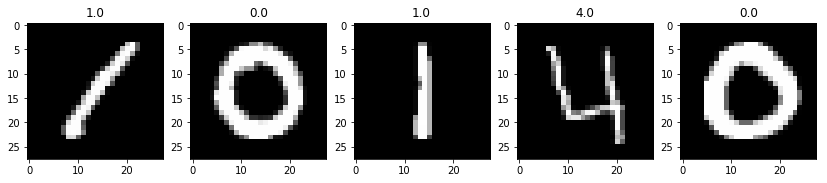

In [15]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
train.shape

(42000, 785)

In [7]:
test.shape

(28000, 784)

In [8]:
data = np.concatenate((train[:, 1:], test), axis = 0)

In [10]:
data.shape

(70000, 784)

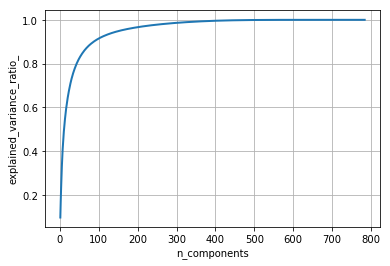

In [11]:
pca = PCA().fit(data)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [12]:
S_thr = 0.95  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(cum_evr > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, cum_evr[n_comp]))

n_comp=153 S=0.950


In [13]:
pca = PCA(n_components=153)

In [14]:
data_trans = pca.fit_transform(data)

In [15]:
data_trans.shape

(70000, 153)

In [16]:
train_pca = data_trans[:42000, :]
test_pca = data_trans[42000:, :]
print(train_pca.shape)
print(test_pca.shape)

(42000, 153)
(28000, 153)


In [18]:
from sklearn.model_selection import train_test_split

y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_pca, test_size=0.2,
    random_state=42)

## Random forest prediction

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
max_depth = np.linspace(1, 20, 20)
n_estimators = list(range(1, 20, 1))

In [90]:
params_grid = { # параметры для RandomForest, которые будем тюнить
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [92]:
grid = {'max_depth': max_depth, 'n_estimators': n_estimators}#, 'max_features': features_num}
gridsearch = GridSearchCV(rfc, params_grid, scoring='accuracy', cv=5)
gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_depth': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [95]:
gridsearch.best_score_

0.90934523809523804

In [96]:
gridsearch.best_params_

{'max_depth': 19.0, 'min_samples_split': 4, 'n_estimators': 19}

In [19]:
rlcfparams = {'max_depth': 19.0, 'min_samples_split': 4, 'n_estimators': 19}

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_estimator = RandomForestClassifier(**rlcfparams)

In [22]:
rf_estimator.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
pred_val_rf = rf_estimator.predict(x_val)

In [29]:
pred_val_rf = np.array(pred_val_rf, dtype=np.int)
pred_val_rf

array([8, 1, 9, ..., 3, 0, 9])

In [34]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val_rf))

Accuracy: 0.912619047619


In [104]:
rf_estimator.fit(train_pca, train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
pred_test = rf_estimator.predict(test_pca)

In [39]:
pred_test = np.array(pred_test, dtype = np.int)

In [40]:
with open('submitrfc1.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))